In [1]:
import pandas as pd
import numpy as np

df = pd.read_table('~/Downloads/INFO_4604/AwarenessVsInfection_month.tsv')

new_df = df.loc[:,['Twitter_content','intent']]
df2 = new_df.rename(index=str, columns={"Twitter_content": "Text", "intent": "Illness"})

df2.head()

,Text,Illness
0,you gotta be kidding me .. everyone around me ...,0
1,getting my flu shot then babysitting .,1
2,my arm is getting sore from that damn flu shot...,1
3,seems like these bird profile pics are spreadi...,1
4,i think i'm in the process of getting the flu ...,0


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

text_train, text_test, Y_train, Y_test = train_test_split(df2['Text'], df2['Illness'], test_size=0.4, random_state=0)

In [3]:
import re
from collections import Counter

def ngrams(tokens, n):
    output = []
    for i in range(n-1, len(tokens)):
        ngram = ' '.join(tokens[i-n+1:i+1])
        output.append(ngram)
    return output

def skipgrams(tokens, n):
    output = []
    for i in range(n-1, len(tokens)):
        str1 = ''
        for j in range(n-2):
            str1 = str1+' * '
        skipgram = str(tokens[i-n+1])+str1+str(tokens[i])
        output.append(skipgram)
    return output

import itertools

def pairs(words):
    ret = itertools.combinations(words,2)
    return ret
   


In [8]:
import nltk

def parts_of_speech(words):
    tagged = []
    
    try:
        tagged = nltk.pos_tag(words)
        return(tagged)
        
    except Exception as e:
        print(e)
    
sentence = 'the quick brown fox jumped over the lazy dog'

parts_of_speech(sentence.split())

[('the', 'DT'),
 ('quick', 'JJ'),
 ('brown', 'NN'),
 ('fox', 'NN'),
 ('jumped', 'VBD'),
 ('over', 'IN'),
 ('the', 'DT'),
 ('lazy', 'JJ'),
 ('dog', 'NN')]

In [26]:
import gensim

def embeddings(text):
    model = gensim.models.Word2Vec(
        text,
        size=100,
        window=5,
        min_count=2,
        workers=10)
    model.train(text, total_examples=len(text), epochs=10)
    
    vectors = model.wv.vectors

In [28]:
def features(text, total_text,  ngram_range=(1,3)):
    text = text.lower()      # make the string lowercase
    text = re.sub(r'(.)\1+', r'\1\1', text)     # remove consecutive characters that are repeated more than twice
    
    features_in_text = []   # running list of all features in this instance (can be repeated)
    
    # treat alphanumeric characters as word tokens (removing anything else),
    # and extract all n-grams of length n specified by ngram_range
    
    text_alphanum = re.sub('[^a-z0-9]', ' ', text)
    for n in range(ngram_range[0], ngram_range[1]+1):
        features_in_text += ngrams(text_alphanum.split(), n)
        #remove sentiment
    
    for n in range(3,5):
        features_in_text += skipgrams(text_alphanum.split(), n)
      
    features_in_text += str(pairs(text_alphanum.split()))
    features_in_text += str(parts_of_speech(text_alphanum.split()))
    # now treat punctuation as word tokens, and get their counts (only unigrams)
    
    text_punc = re.sub('[a-z0-9]', ' ', text)
    features_in_text += ngrams(text_punc.split(), 1)
    
    tweets = []

    for text in total_text:
        tweets.append(text.split())
        
    vecs = embeddings(tweets)
    
   
    # 'Counter' converts a list into a dictionary whose keys are the list elements 
    #  and the values are the number of times each element appeared in the list
    
    return Counter(features_in_text)+Counter(vecs)

In [29]:
from sklearn.feature_extraction import DictVectorizer

vect = DictVectorizer()
X_train = vect.fit_transform(features(d, text_train, ngram_range=(1,3)) for d in text_train)

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score

# this defines the classifier we will use -- don't change this variable

base_classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=123)

# these are the C values we will compare -- don't change this variable

params = [{'C': [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 10.0, 50.0, 100.0]}]

# this performs 5-fold cross-validation with the above classifier and parameter options

gs_classifier = GridSearchCV(base_classifier, params, cv=5)
gs_classifier.fit(X_train, Y_train)

print("Best parameter settings:", gs_classifier.best_params_)
print("Validation accuracy: %0.6f" % gs_classifier.best_score_)

Best parameter settings: {'C': 1.0}
Validation accuracy: 0.801988


In [31]:
scores = cross_val_score(gs_classifier, X_train, Y_train, cv=5)
scores 

array([0.80228137, 0.79007634, 0.80842912, 0.80076628, 0.79310345])



Percentile vs. Accuracy for Ngram Range (1,3)


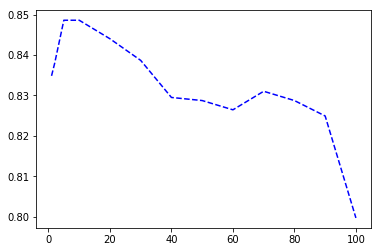

In [32]:
from sklearn.feature_selection import SelectPercentile, chi2
import matplotlib.pyplot as plt

percentiles = [1,2,5,10,20,30,40,50,60,70,80,90,100]
accuracies = []

for p in range(len(percentiles)):
    selection = SelectPercentile(percentile=percentiles[p], score_func=chi2)
    X_train_selected = selection.fit_transform(X_train, Y_train)
    gs_classifier.fit(X_train_selected, Y_train)
    accuracies.append(gs_classifier.best_score_)

print("\n\nPercentile vs. Accuracy for Ngram Range (1,3)")
plt.plot(percentiles, accuracies, 'b--')
plt.show()

In [34]:
X_train_final = vect.fit_transform(features(d, text_train, ngram_range=(1,3)) for d in text_train)
X_test_final = vect.transform(features(d, text_test, ngram_range=(1,3)) for d in text_test)

selection = SelectPercentile(percentile=70, score_func=chi2)
X_train_final = selection.fit_transform(X_train_final, Y_train)
X_test_final = selection.transform(X_test_final)

gs_classifier = GridSearchCV(base_classifier, params, cv=5)
gs_classifier.fit(X_train_final, Y_train)

print("Validation accuracy: %0.6f" % gs_classifier.best_score_)
print("Test accuracy: %0.6f" % accuracy_score(Y_test, gs_classifier.predict(X_test_final)))

scores = cross_val_score(gs_classifier, X_train, Y_train, cv=5)
scores 

Validation accuracy: 0.835627
Test accuracy: 0.786697


array([0.80228137, 0.79007634, 0.80842912, 0.80076628, 0.79310345])